In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import faiss
from matplotlib import pyplot as plt

from recommender.utils.data import (
    filter_transactions,
    filter_nan_age
)

from recommender.recall import (
    ContentBased,
    Item2VecModel,
    popularity_recall,
    postal_code_recall,
    product_code_recall,
    bought_together_recall,
    user_collaborative_recall,
    age_group_recall
)

from recommender.utils.evaluate import (
    calculate_map_at_n, compute_metrics
)

# Resource Paths

In [2]:
image_feature_path = "./feature/dino_image_emb.npy"
text_feature_path = "./feature/glove_text_emb.npy"

# image_cb_euclidean_path = "./feature/image_cb_euclidean.npy"
# text_cb_euclidean_path = "./feature/text_cb_euclidean.npy"

# image_cb_cosine_path = "./feature/image_cb_cosine.npy"
# text_cb_cosine_path = "./feature/text_cb_cosine.npy"

cb_cache_dir = "./feature"

article_path = "./dataset/articles.csv"
customer_path = "./dataset/customers.csv"
fold_split_data_path = "./dataset/split"

# Image & Text Content-Based Pre-Computations 

In [3]:
content_based = ContentBased(
    image_feature_path=image_feature_path,
    text_feature_path=text_feature_path,
    feature_cache_dir=cb_cache_dir
)

# Dataset Loading, Split and Filtering

In [4]:
# Load item data
articles = pd.read_csv(article_path)

# Load user data
customers = pd.read_csv(customer_path)

# TODO: call data split script here
# Load transcation data, splitted according to time
fold_data = {}
for _fold in os.listdir(fold_split_data_path):
    if "fold" in _fold:
        fold_data[_fold] = (
            pd.read_csv(os.path.join(fold_split_data_path, _fold, "train.csv")),
            pd.read_csv(os.path.join(fold_split_data_path, _fold, "test.csv"))
        )

        break

In [5]:
train_df, test_df = fold_data['fold_3']
train_df = content_based.filter_content(train_df, articles)
train_df = filter_nan_age(train_df, customers)
test_df = filter_nan_age(test_df, customers)

train, (loyal_user_test, regular_user_test, new_user_test) = filter_transactions(train_df, test_df)

Condition 1 - Description: Users purchased more than 30 items in training set and more than 10 in testing set
Condition 1 - Train: 1141 users, 60466 transactions, 13710 articles
Condition 1 - Test: 1141 users, 21374 transactions, 6915 articles

Condition 2 - Description: Users purchased more than 5 items but less than 20 items in training set and more than 10 in testing set
Condition 2 - Train: 2459 users, 28762 transactions, 9761 articles
Condition 2 - Test: 2459 users, 38085 transactions, 9403 articles

Condition 3 - Description: Users did not make any purchase in training set, but purchased more than 10 items in testing set
Condition 3 - Train: 0 users, 0 transactions, 0 articles
Condition 3 - Test: 1856 users, 30674 transactions, 8195 articles

Aggregated Info
Train: 3600 users, 76715 transactions, 16366 articles
Test: 5456 users, 74001 transactions, 13705 articles


In [6]:
recall_top_n = 100

# Content Based Single Methods Comparison

In [7]:
img_euclidean_recommend = content_based.recommend_items(train, media="image", dist="euclidean", N=recall_top_n)
img_cosine_recommend = content_based.recommend_items(train, media="image", dist="cosine", N=recall_top_n)
txt_euclidean_recommend = content_based.recommend_items(train, media="text", dist="euclidean", N=recall_top_n)
txt_cosine_recommend = content_based.recommend_items(train, media="text", dist="cosine", N=recall_top_n)

Content-Based with text + cosine: 100%|██████████| 3600/3600 [00:26<00:00, 134.31it/s]


# Rule Filtering Methods Comparison

In [8]:
import matplotlib.pyplot as plt

def compare_recommendations(test_set, recommendations, metrics, top_n):
    # Function to collect metrics for the recommendation on the test set
    def collect_metrics(test_set, recommendations):
        results = {}
        for rec_name, recommendation in recommendations.items():
            results[rec_name] = compute_metrics(recommendation, test_set, top_n=top_n)
        return results

    # Determine layout size based on the input
    num_metrics = len(metrics)
    
    # Set a reasonable figure size dynamically
    fig_width = 24  # Width suitable for one column of plots
    fig_height = num_metrics * 3  # Adjust height based on the number of metrics

    # Get the data
    results = collect_metrics(test_set, recommendations)

    # Create the plots
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(fig_width, fig_height), sharey='row')
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    if num_metrics == 1:
        axes = [axes]  # Ensure axes are iterable even for a single metric

    colors = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange
        '#2ca02c',  # green
        '#d62728',  # red
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # lime green
        '#17becf',  # cyan
        '#393b79',  # dark blue
        '#9c9ede'   # lavender
    ]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        rec_names = list(results.keys())
        values = [results[rec][metric] for rec in rec_names]
        ax.bar(rec_names, values, color=colors, alpha=0.8)
        ax.set_title(f'{metric.capitalize()}')
        ax.set_ylabel(metric.capitalize())
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results

In [9]:
purchase_count = popularity_recall(train=train)

popularity_all = {
    cid: purchase_count['article_id']
    for cid in train['customer_id'].unique()
}

In [10]:
product_code_res = product_code_recall(
    train=train,
    articles=articles,
    purchase_count=purchase_count
)

product_code_recommend = {
    cid: product_code_res[cid]['article_id']
    for cid in train['customer_id'].unique()
}

product_code recall: 100%|██████████| 3600/3600 [00:00<00:00, 7953.80it/s]


In [11]:
postal_code_res, customers_postal_code_map = postal_code_recall(
    train=train,
    customers=customers,
    purchase_count=purchase_count
)

postal_code_recommend = {
    cid: list(postal_code_res[customers_postal_code_map[cid]][:recall_top_n]['article_id'])
    for cid in train['customer_id'].unique()
}

In [12]:
age_group_res, customers_age_group_map = age_group_recall(
    train=train,
    customers=customers,
    purchase_count=purchase_count
)

age_group_recommend = {
    cid: list(age_group_res[customers_age_group_map[cid]][:recall_top_n]['article_id'])
    for cid in train['customer_id'].unique()
}

In [13]:
bought_together_res = bought_together_recall(train=train)

bought_together_recommend = {
    cid: bought_together_res[cid]['article_id']
    for cid in train['customer_id'].unique()
}

bought together recall: 100%|██████████| 3600/3600 [00:13<00:00, 274.91it/s]


# Matrix Factorization Hyper-parameters tuning

In [14]:
test_sets = pd.concat([loyal_user_test, regular_user_test])

mf_grid_search = {
    "factors": [25, 50, 75, 100, 125, 150],
    "alpha": [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    "iterations": [15, 30, 45, 60, 75]
}

mf_hparams_res = {}
for k, options in mf_grid_search.items():
    mf_hparams_res[k] = {}
    for opt in options:
        user_cf_res = user_collaborative_recall(
            train=train,
            top_N=recall_top_n,
            model_cfg={k: opt, 'random_state': 42}
        )
        mf_hparams_res[k][opt] = compute_metrics(user_cf_res, test_sets, recall_top_n)

Start matrix factorization:


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00, 10.49it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  7.93it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:02<00:00,  5.63it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00, 10.11it/s]


Start matrix factorization:


100%|██████████| 30/30 [00:02<00:00, 10.32it/s]


Start matrix factorization:


100%|██████████| 45/45 [00:04<00:00, 10.36it/s]


Start matrix factorization:


100%|██████████| 60/60 [00:05<00:00, 10.13it/s]


Start matrix factorization:


100%|██████████| 75/75 [00:07<00:00, 10.38it/s]


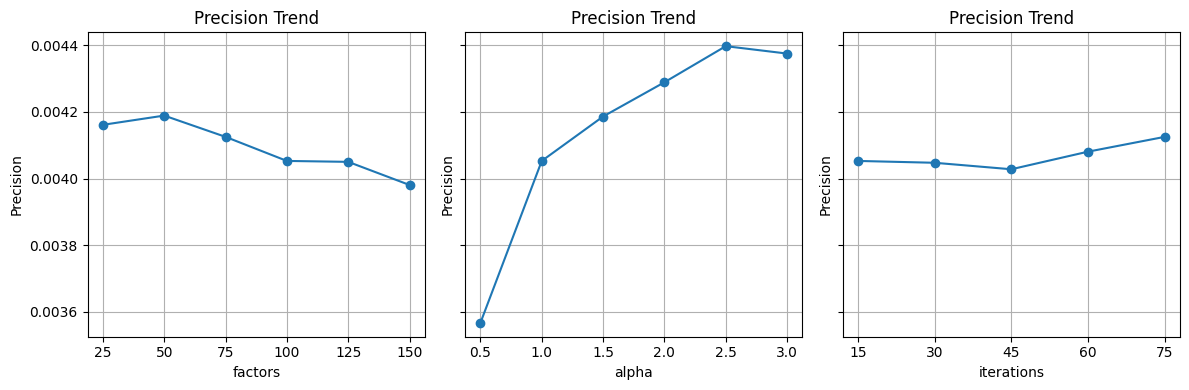

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, (k, hparams_res) in enumerate(mf_hparams_res.items()):
    # Extracting keys and precision values
    keys = list(hparams_res.keys())
    precision_values = [hparams_res[key]['precision'] for key in keys]

    ax = axs[i]
    ax.plot(keys, precision_values, marker='o', linestyle='-')
    ax.set_title('Precision Trend')
    ax.set_xlabel(f'{k}')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.set_xticks(keys)  # Ensure all keys are marked on x-axis

plt.tight_layout()
plt.show()

In [16]:
user_cf_recommend = user_collaborative_recall(
    train=train,
    top_N=recall_top_n,
    model_cfg={
        'factors': 50,
        'alpha': 2.5,
        'iterations': 15,
        'random_state': 42
    }
)

Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00, 11.31it/s]


# Item2Vec Model Hyper-parameter Tuning

In [17]:
test_sets = pd.concat([loyal_user_test, regular_user_test])

i2v_default = {
    "window": 9999,
    "seed": 42,
}
i2v_grid_search = {
    "vector_size": [50, 100, 150, 200, 250],
    "sample": [1.e-2, 1.e-3, 1.e-4, 1.e-5],
    "epochs": [5, 10, 15, 20, 25],
    "negative": [1, 5, 10, 15, 20]
}

i2v_hparams_pop_res = {}
i2v_hparams_sim_res = {}

for k, options in i2v_grid_search.items():
    i2v_hparams_pop_res[k] = {}
    i2v_hparams_sim_res[k] = {}
    for opt in options:
        cfg = i2v_default.copy()
        cfg.update({k: opt})
        i2v_model = Item2VecModel(
            train=train,
            top_N=recall_top_n,
            articles=articles,
            model_cfg=cfg
        )
        i2v_hparams_pop_res[k][opt] = compute_metrics(i2v_model.cluster_recall(), test_sets, recall_top_n)
        i2v_hparams_sim_res[k][opt] = compute_metrics(i2v_model.similarity_recall(), test_sets, recall_top_n)

item2vec similarity computation (cpu): 100%|██████████| 4511/4511 [00:00<00:00, 5678.01it/s]


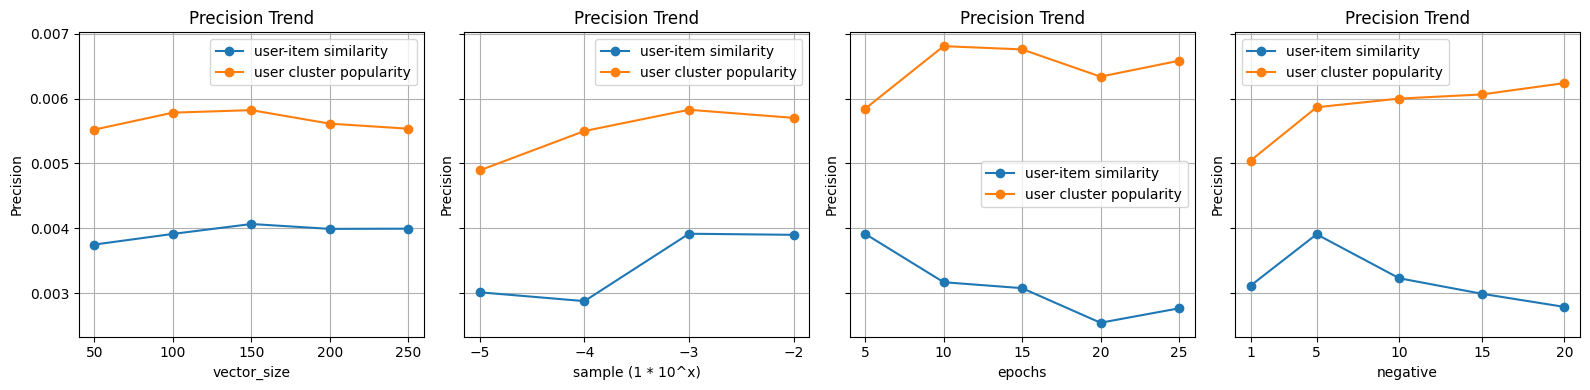

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, k in enumerate(i2v_hparams_sim_res):
    # Extracting keys and precision values
    keys = list(i2v_hparams_sim_res[k].keys())
    sim_precision_values = [i2v_hparams_sim_res[k][key]['precision'] for key in keys]
    pop_precision_values = [i2v_hparams_pop_res[k][key]['precision'] for key in keys]

    if k == "sample":
        keys = [np.log10(opt) for opt in keys]
        k = "sample (1 * 10^x)"
    ax = axs[i]
    ax.plot(keys, sim_precision_values, marker='o', linestyle='-', label="user-item similarity")
    ax.plot(keys, pop_precision_values, marker='o', linestyle='-', label="user cluster popularity")
    ax.set_title('Precision Trend')
    ax.set_xlabel(f'{k}')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.set_xticks(keys)  # Ensure all keys are marked on x-axis
    ax.legend()
    
plt.tight_layout()
plt.show()

In [19]:
item2vec = Item2VecModel(
    train=train,
    articles=articles,
    top_N=recall_top_n,
    model_cfg={
        "window": 9999,
        "seed": 42,
        "vector_size": 100,
        "sample": 1.e-3,
        "epochs": 10,
        "negative": 5
    }
)

item2vec data prepare: 100%|██████████| 3600/3600 [00:00<00:00, 9462.68it/s] 


In [20]:
item2vec_cls_res = item2vec.cluster_recall()
item2vec_sim_res = item2vec.similarity_recall()

item2vec similarity computation (cpu): 100%|██████████| 4511/4511 [00:00<00:00, 5574.52it/s]


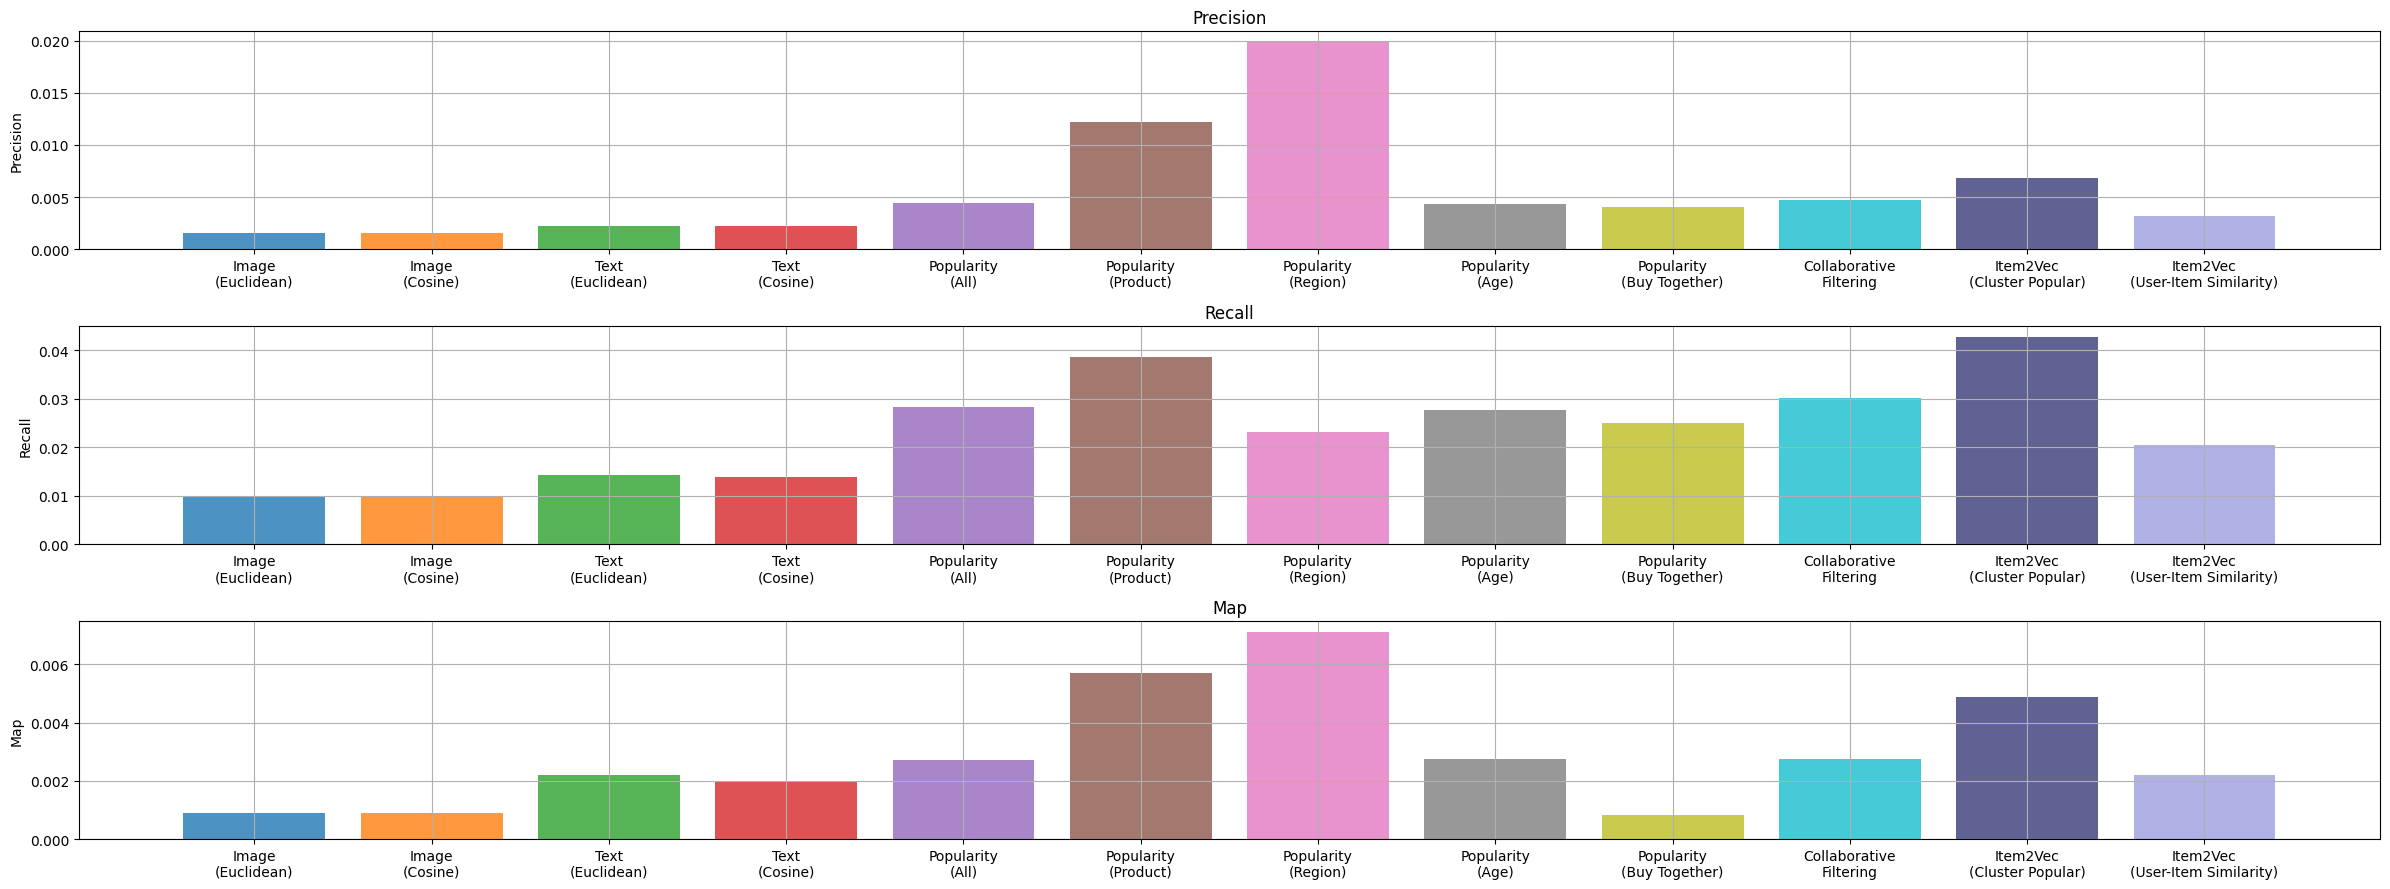

In [26]:
# test_sets = {'Loyal User Test': loyal_user_test, 'Regular User Test': regular_user_test}
test_sets = pd.concat([loyal_user_test, regular_user_test])

recommendations = {
    'Image\n(Euclidean)': img_euclidean_recommend,
    'Image\n(Cosine)': img_cosine_recommend,
    'Text\n(Euclidean)': txt_euclidean_recommend,
    'Text\n(Cosine)': txt_cosine_recommend,
    'Popularity\n(All)': popularity_all,
    'Popularity\n(Product)': product_code_recommend,
    'Popularity\n(Region)': postal_code_recommend,
    'Popularity\n(Age)': age_group_recommend,
    'Popularity\n(Buy Together)': bought_together_recommend,
    'Collaborative\nFiltering': user_cf_recommend,
    'Item2Vec\n(Cluster Popular)': item2vec_cls_res,
    'Item2Vec\n(User-Item Similarity)': item2vec_sim_res,
}
metrics = ['precision', 'recall', 'map']

eval_result = compare_recommendations(test_sets, recommendations, metrics, top_n=recall_top_n)

In [25]:
pd.DataFrame(eval_result).transpose()

,purchased,hit_num,precision,recall,recall_num,map
Image\n(Euclidean),16.516389,0.152778,0.001528,0.009773,100.000000,0.000907
Image\n(Cosine),16.516389,0.150556,0.001506,0.009670,100.000000,0.000887
Text\n(Euclidean),16.516389,0.223889,0.002239,0.014176,100.000000,0.002185
Text\n(Cosine),16.516389,0.217778,0.002178,0.013802,100.000000,0.002003
Popularity\n(All),16.516389,0.439444,0.004394,0.028276,100.000000,0.002719
Popularity\n(Product),16.516389,0.615000,0.012168,0.038638,53.585000,0.005695
Popularity\n(Region),16.516389,0.376944,0.019923,0.023074,20.876944,0.007122
Popularity\n(Age),16.516389,0.429444,0.004306,0.027656,99.962222,0.002764
Popularity\n(Buy Together),16.516389,0.405278,0.004053,0.025032,94.725000,0.000834
Collaborative\nFiltering,16.516389,0.471944,0.004719,0.030160,100.000000,0.002763


# Aggregated Evaluation

In [ ]:
recommendations = {
    'Image\n(Euclidean)': img_euclidean_recommend,
    'Image\n(Cosine)': img_cosine_recommend,
    'Text\n(Euclidean)': txt_euclidean_recommend,
    'Text\n(Cosine)': txt_cosine_recommend,
    'Popularity\n(All)': popularity_all,
    'Popularity\n(Product)': product_code_recommend,
    'Popularity\n(Region)': postal_code_recommend,
    'Popularity\n(Age)': age_group_recommend,
    'Popularity\n(Buy Together)': bought_together_recommend,
    'Collaborative\nFiltering': user_cf_recommend,
    'Item2Vec\n(Cluster Popular)': item2vec_cls_res,
    'Item2Vec\n(User-Item Similarity)': item2vec_sim_res,
}

In [41]:
import itertools

class Aggregate:
    def __init__(self, recommend):
        self.recommend = recommend
        self.aggregate_recommend = []

    def register_recall(self, customer_id, purchased, all_items, recall_pipes: dict):
        res = {}
        # initialize recall dict for all items
        for item in all_items:
            res[item] = {}
            for k in recall_pipes:
                res[item][k] = 0
                res[item][f"{k}_score"] = 0.0
                res[item]['purchased'] = int(item in purchased)
                res[item]['customer_id'] = customer_id
                res[item]['article_id'] = item

        for k in recall_pipes:
            recalled_num = len(recall_pipes[k])
            for i, item in enumerate(recall_pipes[k]):
                res[item][k] = 1
                res[item][f"{k}_score"] = (recalled_num - i) / recalled_num

        self.aggregate_recommend.extend(res.values())

    def aggregate(self, test_set, train, keys, top_n: int):
        purchase_dict = test_set.groupby('customer_id')['article_id'].agg(list)

        test_users = set(train['customer_id']).intersection(list(purchase_dict.keys()))

        for cid in tqdm(test_users, desc="Aggregrating recall results"):
            purchased = purchase_dict[cid]

            _res = {k: self.recommend[k][cid][:top_n] for k in keys}

            together_recall = set(itertools.chain(*_res.values()))
            
            self.register_recall(
                customer_id=cid,
                purchased=purchased,
                all_items=together_recall,
                recall_pipes=_res
            )

        aggregated_df = pd.DataFrame(self.aggregate_recommend)

        return aggregated_df

In [42]:
_recommend = {
    'img_euclidean': img_euclidean_recommend,
    'img_cosine': img_cosine_recommend,
    'txt_euclidean': txt_euclidean_recommend,
    'txt_cosine': txt_cosine_recommend,
    'popularity_all': popularity_all,
    'product_code': product_code_recommend,
    'postal_code': postal_code_recommend,
    'age_group': age_group_recommend,
    'bought_together': bought_together_recommend,
    'user_cf': user_cf_recommend,
    'item2vec_cls_res': item2vec_cls_res,
    'item2vec_sim_res': item2vec_sim_res,
}

In [43]:
agg = Aggregate(_recommend)

In [44]:
agg.aggregate(
    test_set=pd.concat([loyal_user_test, regular_user_test]),
    train=train,
    keys=list(_recommend.keys()),
    top_n=recall_top_n
)

Aggregrating recall results: 100%|██████████| 3600/3600 [00:44<00:00, 80.51it/s] 


,img_euclidean,img_euclidean_score,purchased,customer_id,article_id,img_cosine,img_cosine_score,txt_euclidean,txt_euclidean_score,txt_cosine,...,age_group,age_group_score,bought_together,bought_together_score,user_cf,user_cf_score,item2vec_cls_res,item2vec_cls_res_score,item2vec_sim_res,item2vec_sim_res_score
0,0,0.0,0,75b7b5a187b64ea3e9c33f2391467a401f31b1ecbddfd8...,828928001,0,0.0,0,0.00,0,...,0,0.00,0,0.0,0,0.00,1,0.68,0,0.00
1,0,0.0,0,75b7b5a187b64ea3e9c33f2391467a401f31b1ecbddfd8...,651690001,0,0.0,1,0.62,1,...,0,0.00,0,0.0,0,0.00,0,0.00,0,0.00
2,0,0.0,0,75b7b5a187b64ea3e9c33f2391467a401f31b1ecbddfd8...,824490001,0,0.0,0,0.00,0,...,0,0.00,0,0.0,0,0.00,1,0.05,0,0.00
3,0,0.0,0,75b7b5a187b64ea3e9c33f2391467a401f31b1ecbddfd8...,719530003,0,0.0,0,0.00,0,...,1,0.13,0,0.0,0,0.00,0,0.00,1,0.90
4,0,0.0,0,75b7b5a187b64ea3e9c33f2391467a401f31b1ecbddfd8...,724906006,0,0.0,1,0.08,1,...,0,0.00,0,0.0,0,0.00,0,0.00,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319500,0,0.0,0,40f2034873b58fb4a5adc1def3982a31a20762804fbaec...,587137009,0,0.0,0,0.00,0,...,0,0.00,0,0.0,0,0.00,0,0.00,1,0.68
2319501,0,0.0,0,40f2034873b58fb4a5adc1def3982a31a20762804fbaec...,829014002,0,0.0,0,0.00,0,...,0,0.00,0,0.0,1,0.92,0,0.00,0,0.00
2319502,0,0.0,0,40f2034873b58fb4a5adc1def3982a31a20762804fbaec...,733782005,0,0.0,0,0.00,0,...,0,0.00,0,0.0,0,0.00,0,0.00,1,0.53
2319503,0,0.0,0,40f2034873b58fb4a5adc1def3982a31a20762804fbaec...,855851001,0,0.0,0,0.00,0,...,0,0.00,0,0.0,0,0.00,1,0.28,0,0.00
